# <b>Overview:</b>

Unstructured data belonging to the enterprise continues to grow, making it a challenge for customers and employees to get the information they need. Amazon Kendra (https://aws.amazon.com/kendra/) is a highly accurate intelligent search service powered by machine learning (ML). It helps you easily find the content you’re looking for, even when it’s scattered across multiple locations and content repositories.

To help narrow down a list of relevant documents, you can assign metadata at the time of document ingestion to provide filtering and faceting capabilities, for an experience similar to the Amazon.com (http://amazon.com/) retail site where you’re presented with filtering options on the left side of the webpage. But what if the original documents have no metadata, or users have a preference for how this information is categorized? You can automatically enrich the content and make it easier to search and discover using this lab .

This lab illustrates how you can automate and simplify metadata generation using Amazon Comprehend (https://aws.amazon.com/comprehend/), a natural language processing (NLP) service that uses ML to find insights from text and Amazon Kendra. The metadata generated can be customized during the ingestion process with Amazon Kendra CDE (https://docs.aws.amazon.com/kendra/latest/dg/custom-document-enrichment.html) (Custom Document Enrichment) custom logic.

For this lab we use Wikipedia pages of 200 US and Canada universities. We ingest this content and automatically generate content metadata using Amazon Kendra CDE custom logic with Amazon Comprehend APIs, into a unified Amazon Kendra index to make it searchable. Finally, we use the Amazon Kendra search page to show how the metadata enhanced the search capability by adding faceting and filtering capability.

<b>Architecture Diagram:</b>

<br />
<br />

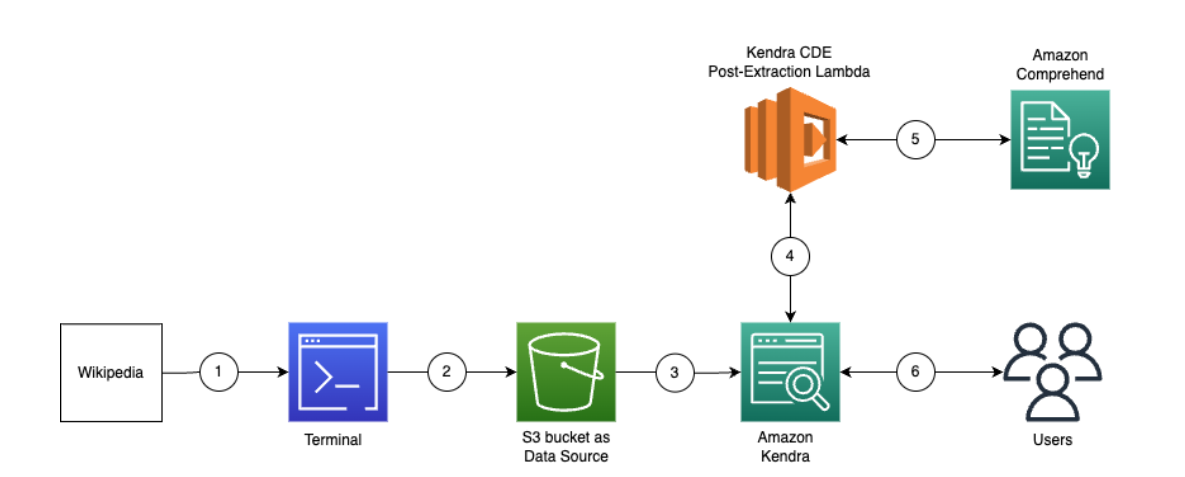


You will perform the following steps in this notebook:

1. Setup prerequisites and download the university Wikipedia pages.
2. Copy the text to an Amazon S3 bucket that is configured as a data source to the Amazon Kendra index using the S3 connector.
3. Ingest the page data to the Amazon Kendra Index.
4. Use Kendra - Custom Document Enrichment (CDE) post-extraction lambda and call Amazon Comprehend.
5. Amazon Comprehend identifies top entities of types COMMERCIAL_ITEM, DATE, EVENT, LOCATION, ORGANIZATION, OTHER, PERSON, QUANTITY, TITLE.
6. Run search queries in Amazon Kendra, using the extracted metadata from Amazon Comprehend to filter and facet the search results.


# 1. Setup

This lab requires AWS Admin/Sagemaker role and policies that grant permission for:

* S3 bucket create/delete/get/put
* CloudFormation create/delete/describe stack
* IAM getRole/createRole/passRole
* Comprehend detect_entities
* Lambda create
* and, Kendra full access



In [ ]:
# load required libraries
import sagemaker
import boto3
from datetime import datetime
from botocore.exceptions import ClientError
import pprint
import time
import json
import os

In [ ]:
# extract AWS region and IAM role information
region = boto3.Session().region_name    
session = sagemaker.Session()
sagemaker_role = sagemaker.get_execution_role()
account_id =  boto3.client('sts').get_caller_identity()['Account']
sagemaker_role_name = sagemaker_role[sagemaker_role.index("/")+1:]

In [ ]:
# check the role, account, and region
print(sagemaker_role)
print(account_id)
print(region)

<b>1.1 Run setup.sh:</b>

In order to download the wikipedia pages, we will use lynx browser. This setup script does the following:<br />
a. installs the lynx browser which is used later to download the wikipedia pages. <br />
b. creates local directories for Data 


In [ ]:
%%sh
sh ./setup.sh

<b>1.2 Run getpages.sh:</b>

The file, universities.txt, contains a list of 200 American and Canadian universities, each of which has a Wikipedia page for us to download. This getpages.sh script uses the lynx broswer command to download each university page to the local Data directory. It takes about 20 seconds to run.

In [ ]:
%%sh
sh ./getpages.sh

# <b>2. Upload text files to S3 </b>


For this lab, we are going to use the same S3 bucket for <br />
<br /> 1. Kendra data source 
<br /> 2. Kendra post extraction metadata
<br /> 3. source for CloudFormation template
<br /> <br />
However, separate S3 bucket can be created and used as per the use case.

In [ ]:
# specify S3 bucket name here to use as a Kendra data source.
bucket_name = "comprehendlab-" + str(int(datetime.now().replace(microsecond=0).timestamp()))
bucket_name

In [ ]:
# create a prefix/key for copying the wikipedia pages from local folder ‘Data’ to S3 bucket we created earlier.
prefix = 'Data/University_Data/'

In [ ]:
# let's create S3 client for the S3 bucket operations
s3_client = boto3.client('s3')
s3_client.create_bucket(Bucket=bucket_name)

In [ ]:
# copy downloaded wiki pages to the S3 bucket prefix created above
local_dir = './Data'
for file in os.listdir(local_dir):
    s3_client.upload_file(f'{local_dir}/{file}', bucket_name, f'{prefix}{file}')

In [ ]:
# since we will be using S3 url as the source of CloudFormation template file, 
# we need to upload this yaml file from Notebook instance's local folder to S3 bucket
cfn_template = "lab8bkendra-comprehend-notebook.yaml"
response = s3_client.upload_file(cfn_template, bucket_name, cfn_template)

# 3. Lets create IAM roles required for the lab. We will create three IAM roles with least privilege permissions.<br />
1. KendraDSRole: the role needed to attach the S3 Data Source <br />
2. KendraIndexRole: the role needed to create a Kendra Index <br />
3. KendraLambdaRole: the role assigned to the lambda function that is invoked as part of Custom Document Enrichment <br />

In [ ]:
# Create IAM client for creating roles, trust relationships, and associated policieis
iam = boto3.client('iam')
kendra_data_source_role = 'KendraDSRole'
kendra_index_role = 'KendraIndexRole'
kendra_lambda_role = 'KendraLambdaRole'

<b>3.1 Let's start by creating the role to be used for creating the Kendra index </b>

In [ ]:
# this is the trust relationship that Kendra index and Kendra data source roles will have with the Kendra service
trust_relationship_policy_kendra_service = json.dumps({
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                    "Service":"kendra.amazonaws.com"
                },
            "Action": "sts:AssumeRole"
        }
    ]
})

In [ ]:
# create the role with the above trust policy
kendra_index_role_response = iam.create_role(
        RoleName=kendra_index_role,
        AssumeRolePolicyDocument=trust_relationship_policy_kendra_service,
        Description='This role is used to create Kendra Index'
)

In [ ]:
# Define and create a policy for KendraIndexRole
kendra_index_policy = json.dumps({
    "Version": "2012-10-17",
    "Statement": [
        {
            "Condition": {
                "StringEquals": {
                    "cloudwatch:namespace": "Kendra"
                }
            },
            "Action": [
                "cloudwatch:PutMetricData"
            ],
            "Resource": "*",
            "Effect": "Allow"
        },
        {
            "Action": "logs:DescribeLogGroups",
            "Resource": "*",
            "Effect": "Allow"
        },
        {
            "Action": "logs:CreateLogGroup",
            "Resource": f"arn:aws:logs:{region}:{account_id}:log-group:/aws/kendra/*",
            "Effect": "Allow"
        },
        {
            "Action": [
                "logs:DescribeLogStreams",
                "logs:CreateLogStream",
                "logs:PutLogEvents"
            ],
            "Resource": f"arn:aws:logs:{region}:{account_id}:log-group:/aws/kendra/*:log-stream:*",
            "Effect": "Allow"
        }
    ]
})

# create the policy
response = iam.create_policy(
  PolicyName='KendraLab8IndexPolicy',
  PolicyDocument=kendra_index_policy
)

In [ ]:
# now attach the policy with the Kendra index role
response = iam.attach_role_policy(
    RoleName=kendra_index_role,
    PolicyArn=f"arn:aws:iam::{account_id}:policy/KendraLab8IndexPolicy"
)

<b>3.2 Create role for Kendra Data Source </b>
<br /> We will attach the required least privilege policy <u>after</u> Kendra Index is created since Kendra Data Source policy refers to Kendra Index Id.

In [ ]:
# create Kendra data source role
kendra_ds_role_response = iam.create_role(
        RoleName=kendra_data_source_role,
        AssumeRolePolicyDocument=trust_relationship_policy_kendra_service,
        Description='This role is used to create Kendra S3 data source'
)

<b>3.3 Create role for Lambda function </b>
<br /> We will attach the policy after Kendra Index is created since Kendra Data Source policy refers to Kendra Index Id.

In [ ]:
# create trust policy for lambda service
trust_relationship_policy_lambda_service = json.dumps({
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                    "Service":"lambda.amazonaws.com"
                },
            "Action": "sts:AssumeRole"
        }
    ]
})

In [ ]:
# create lambda role
kendra_lambda_role_response = iam.create_role(
        RoleName=kendra_lambda_role,
        AssumeRolePolicyDocument=trust_relationship_policy_lambda_service,
        Description='This role is used to create post extract Lambda function'
)
kendra_lambda_role_response

In [ ]:
# Create a policy for Lambda role
kendra_lambda_policy = json.dumps({
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "s3:GetObject",
                "s3:PutObject"
            ],
            "Resource": f"arn:aws:s3:::{bucket_name}/*",
            "Effect": "Allow"
        },
        {
            "Action": "s3:ListBucket",
            "Resource": f"arn:aws:s3:::{bucket_name}",
            "Effect": "Allow"
        },
        {
            "Action": "lambda:InvokeFunction",
            "Resource": f"arn:aws:lambda:{region}:{account_id}:function:ComprehendLab8-postextractionlambda-*",
            "Effect": "Allow"
        },
        {
            "Action": [
                "logs:CreateLogGroup",
                "logs:CreateLogStream",
                "logs:PutLogEvents"
            ],
            "Resource": "*",
            "Effect": "Allow"
        },
        {
            "Action": [
                "comprehend:DetectEntities"
            ],
            "Resource": "*",
            "Effect": "Allow"
        }
    ]
})

response = iam.create_policy(
  PolicyName='KendraLab8LambdaPolicy',
  PolicyDocument=kendra_lambda_policy
)

In [ ]:
# attach least privilege policy to the role
response = iam.attach_role_policy(
    RoleName=kendra_lambda_role,
    PolicyArn=f"arn:aws:iam::{account_id}:policy/KendraLab8LambdaPolicy"
)
response

<b>3.4 Create trust policy for cloudformation </b>
<br /> We will attach the policy to run the cloudformation stack creation. this stack creates the post-extraction lambda function

In [ ]:
# identify the assume role policy for the role running this notebook/sagemaker session
iam_resource = boto3.resource('iam')
assume_role_policy = iam_resource.AssumeRolePolicy(sagemaker_role_name)

In [ ]:
# the below defined policy is required to ensure that the sagemaker role is enabled to create cloudformation stacks
trust_relationship_policy_cloudform_service = json.dumps({
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                    "Service":"cloudformation.amazonaws.com"
                },
            "Action": "sts:AssumeRole"
        },
         {
            "Effect": "Allow",
            "Principal": {
                    "Service":"sagemaker.amazonaws.com"
                },
            "Action": "sts:AssumeRole"
        }
    ]
})
response = assume_role_policy.update(
    PolicyDocument=trust_relationship_policy_cloudform_service
)
response

# 4. Create lambda function for post extraction enrichment

<b> How Kendra-CDE post extraction Lambda detects the entities </b>

The post-extraction Lambda function allows you to implement the logic to process the text extracted by Amazon Kendra from the ingested document, then create and update the metadata. The post-extraction function we configured implements the code to invoke Amazon Comprehend to detect entities from the text extracted by Amazon Kendra, and uses them to update the document metadata, which is presented as facets in an Amazon Kendra search. The function code is embedded in the CloudFormation template we used earlier. You can choose the Template tab of the stack on the CloudFormation console and review the code for PostExtractionLambda.

* Splits the page text into sections that do not exceed the max byte length limit of the comprehend detect_entities API. (See Limits (https://docs.aws.amazon.com/comprehend/latest/dg/guidelines-and-limits.html)). NOTE the script uses a naive character length splitting algorithm for simplicity - production use cases should implement overlapping or sentence boundary splits, based on UTF8 byte length.
* For each section of the text, calls the comprehend detect_entities(API) to detect the following entity types: ["COMMERCIAL_ITEM", "DATE", "EVENT", "LOCATION", "ORGANIZATION", "OTHER", "PERSON", "QUANTITY", "TITLE"]
* Filters out detected entities that are below the threshold confidence score. We are using 0.97 threshold which means only entities with 97% and more will be used.
* Tracks the frequency count of each remaining entity
* De-duplicates entities
* Selects only the top N (10) unique entities for each page, based on occurrence frequency

Note that at this time CDE only supports synchronous calls or if it has to be asynchronous, then an explicit wait loop is needed. For post extraction lambda the max execution time is 1 min. Hence async calls can be tricky to manage. The lambda custom logic can be changed based on the requirements which fits your need. 
Additionally, Comprehend custom entity recognition method could be used which extends the capability of Amazon Comprehend by helping you identify your specific new entity types that are not in the preset generic entity types (https://docs.aws.amazon.com/comprehend/latest/dg/how-entities.html).


<b>Run CloudFormation template to create the Lambda function using least privileged role created in 3.3 above </b>

In [ ]:
# create cloudformation client
cloudformation = boto3.client('cloudformation')

In [ ]:
# create the lambda function through CLoudFormation stack 
# the stack takes the above created lambda role as a parameter, creates the lambda function and outputs ARN of the lambda function
response_cfn = cloudformation.create_stack(
    StackName='ComprehendLab8',
    TemplateURL=f"https://{bucket_name}.s3.amazonaws.com/{cfn_template}",
    Parameters=[
        {
            'ParameterKey': 'KendraLambdaRole',
            'ParameterValue': f'arn:aws:iam::{account_id}:role/{kendra_lambda_role}'
        },
    ],
    DisableRollback=False,
    TimeoutInMinutes=30,
    RoleARN=sagemaker_role,
    Tags=[
        {
            'Key': 'env',
            'Value': 'development'
        }
    ]
)


In [ ]:
# save the ARN of lambda function in a variable
outputs_cfn = cloudformation.describe_stacks(StackName='ComprehendLab8')["Stacks"][0]["Outputs"]
lambda_arn = outputs_cfn[0]["OutputValue"]

# 5. Create a Kendra index

Creating a new Kendra index can take some time. let's start the process.

In [ ]:
# create Kendra client
kendra = boto3.client("kendra")

In [ ]:
# Provide a name for the index
index_name = "Lab8UniversityIndex"
# Provide an optional description for the index
index_description = "Demo index for universities"

If you see CREATE_IN_PROGRESS then it's not done yet. It usually takes about 20-25 minutes for this lab, so you might have time for a quick break.
When the StackStatus is CREATE_COMPLETE, you are ready to proceed.
Or, go back and have a look at the lambda python script (generated as part of CloudFormation stack) - think about how it works, how you could make it better, or customize it for your own use cases.

In [ ]:
try:
    index_response = kendra.create_index(
        Name = index_name,
        Description = index_description,
        Edition='DEVELOPER_EDITION',
        RoleArn = f"arn:aws:iam::{account_id}:role/{kendra_index_role}"
    )

    pprint.pprint(index_response)

    index_id = index_response["Id"]

    print("Wait for Amazon Kendra to create the index.")

    while True:
        # Get the details of the index, such as the status
        index_desc = kendra.describe_index(
            Id = index_id
        )
        # If status is not CREATING, then quit
        status = index_desc["Status"]
        print(" Creating index. Status: "+status)
        if status != "CREATING":
            break
        time.sleep(60)

except  ClientError as e:
        print("%s" % e)

Once the index is created, we will update the index with metadata configuration. <br />
We are using nine fields, three of which are faceted (LOCATION, PERSON, ORGANIZATION). 

In [ ]:
# define metadata configuration
DocumentMetadataConfiguration = [
        {
            'Name': 'COMMERCIAL_ITEM',
            'Type': 'STRING_LIST_VALUE',
            'Search': {
                'Facetable': False,
                'Searchable': False,
                'Displayable': False
            } 

        },
        {
            'Name': 'DATE',
            'Type': 'STRING_LIST_VALUE',
            'Search': {
                'Facetable': False,
                'Searchable': False,
                'Displayable': False
            } 

        },
        {
            'Name': 'EVENT',
            'Type': 'STRING_LIST_VALUE',
            'Search': {
                'Facetable': False,
                'Searchable': False,
                'Displayable': False
            } 

        },
        {
            'Name': 'LOCATION',
            'Type': 'STRING_LIST_VALUE',
            'Search': {
                'Facetable': True,
                'Searchable': False,
                'Displayable': False
            } 

        },
        {
            'Name': 'ORGANIZATION',
            'Type': 'STRING_LIST_VALUE',
            'Search': {
                'Facetable': True,
                'Searchable': False,
                'Displayable': False
            } 

        },
        {
            'Name': 'OTHER',
            'Type': 'STRING_LIST_VALUE',
            'Search': {
                'Facetable': False,
                'Searchable': False,
                'Displayable': False
            } 

        },
        {
            'Name': 'PERSON',
            'Type': 'STRING_LIST_VALUE',
            'Search': {
                'Facetable': True,
                'Searchable': False,
                'Displayable': False
            } 

        },
        {
            'Name': 'QUANTITY',
            'Type': 'STRING_LIST_VALUE',
            'Search': {
                'Facetable': False,
                'Searchable': False,
                'Displayable': False
            } 

        },
        {
            'Name': 'TITLE',
            'Type': 'STRING_LIST_VALUE',
            'Search': {
                'Facetable': False,
                'Searchable': False,
                'Displayable': False
            } 

        }
]

# call index update with the above defined metadata configuration
index_update_response = kendra.update_index(
        Id = index_id,
        DocumentMetadataConfigurationUpdates = DocumentMetadataConfiguration
    )

<b>This concludes the Kendra index creation part.</b>

# 6. Using an S3 data source for the Kendra Index

<b>6.1 Define and attach policy to Kendra data source role.</b> <br />
In section 3.2 above, we created the role for Kendra data source. <br />
Now that the Kendra index and lambda function are created, we will proceed with least privileged polciy and attach it to the role.

In [ ]:
# Create a policy for KendraDSRole
kendra_data_source_policy = json.dumps({
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "s3:GetObject",
                "s3:PutObject"
            ],
            "Resource": f"arn:aws:s3:::{bucket_name}/*",
            "Effect": "Allow"
        },
        {
            "Action": "s3:ListBucket",
            "Resource": f"arn:aws:s3:::{bucket_name}",
            "Effect": "Allow"
        },
        {
            "Action": [
                "kendra:BatchPutDocument",
                "kendra:BatchDeleteDocument"
            ],
            "Resource": f"arn:aws:kendra:{region}:{account_id}:index/{index_id}",
            "Effect": "Allow"
        },
        {
            "Action": "lambda:InvokeFunction",
            "Resource": lambda_arn,
            "Effect": "Allow"
        }
    ]
})

response = iam.create_policy(
  PolicyName='KendraLab8DSPolicy',
  PolicyDocument=kendra_data_source_policy
)

In [ ]:
# attach the least privilege policy
response = iam.attach_role_policy(
    RoleName=kendra_data_source_role,
    PolicyArn=f"arn:aws:iam::{account_id}:policy/KendraLab8DSPolicy"
)

<b> 6.2 Configure and create Kendra data source </b><br />

In [ ]:
# Provide a name for the data source
name = "UniversityDataSource"
# Provide an optional description for the data source
description = "Demo data source for universities."
# Provide the IAM role ARN required for data sources
role_arn = f'arn:aws:iam::{account_id}:role/{kendra_data_source_role}'
type = "S3"
# Configure the data source
configuration = {
    "S3Configuration":{
        "BucketName": bucket_name,
        'InclusionPrefixes': [prefix],
        'DocumentsMetadataConfiguration': {
                'S3Prefix': '/'
            }
    }
}

#configure Custom Document Enrichment
cde_configuration = {
    'InlineConfigurations': [
            {
                'Condition': {
                    'ConditionDocumentAttributeKey': '_source_uri',
                    'Operator': 'Contains',
                    'ConditionOnValue': {
                        'StringValue': 'University_Data'
                    }
                },
                'Target': {
                    'TargetDocumentAttributeKey': '_category',
                    'TargetDocumentAttributeValueDeletion': False,
                    'TargetDocumentAttributeValue': {
                        'StringValue': 'University_Data'
                    }
                },
                'DocumentContentDeletion': False
            },
        ],
    'PostExtractionHookConfiguration': {
            'InvocationCondition': {
                'ConditionDocumentAttributeKey': '_source_uri',
                'Operator': 'Contains',
                'ConditionOnValue': {
                    'StringValue': 'University_Data'
                }
            },
            'LambdaArn': lambda_arn,
            'S3Bucket': bucket_name
        },
        'RoleArn': role_arn
}

data_source_response = kendra.create_data_source(
    Configuration = configuration,
    Name = name,
    Description = description,
    RoleArn = role_arn,
    Type = type,
    IndexId = index_id,
    CustomDocumentEnrichmentConfiguration = cde_configuration
)

It can take some time to create your data source. You can monitor the progress by using the DescribeDataSource API. When the data source status is ACTIVE the data source is ready to use. 

In [ ]:
while True:
        data_source_description = kendra.describe_data_source(
            Id = data_source_response["Id"],
            IndexId = index_id
        )
        status = data_source_description["Status"]
        print(" Creating data source. Status: "+status)
        time.sleep(60)
        if status != "CREATING":
            break

This data source doesn't have a schedule, so it doesn't run automatically. To index the data source, you call StartDataSourceSyncJob to synchronize the index with the data source.

# 7. <b>Populate the Amazon Kendra index</b>

In this step you will use the Amazon Kendra search index we created earlier. You will populate it with the university page data, using the extracted entities for each university as index metadata, so that you can filter searches based on the entity types.


In [ ]:
# This will start the ingestion process, and ingest the wiki pages from the S3 bucket.
sync_response = kendra.start_data_source_sync_job(
        Id = data_source_response["Id"],
        IndexId = index_id
    )

It might take 7-8 minutes to sync all 200 documents. When the data source sync job has finished syncing, the status is SUCCEEDED. 

In [ ]:
while True:

        jobs = kendra.list_data_source_sync_jobs(
            Id= data_source_response["Id"],
            IndexId= index_id
        )

        # For this example, there should be one job
        status = jobs["History"][0]["Status"]

        print(" Syncing data source. Status: "+status)
        time.sleep(60)
        if status != "SYNCING":
            break

# 8. <b>Use the extracted entities to filter searches in Kendra</b>

Finally, your index is populated and ready to use.
In the Amazon Kendra console, under UniversityIndex choose *Search Indexed Content under Data Management* and perform the below searches:<br />

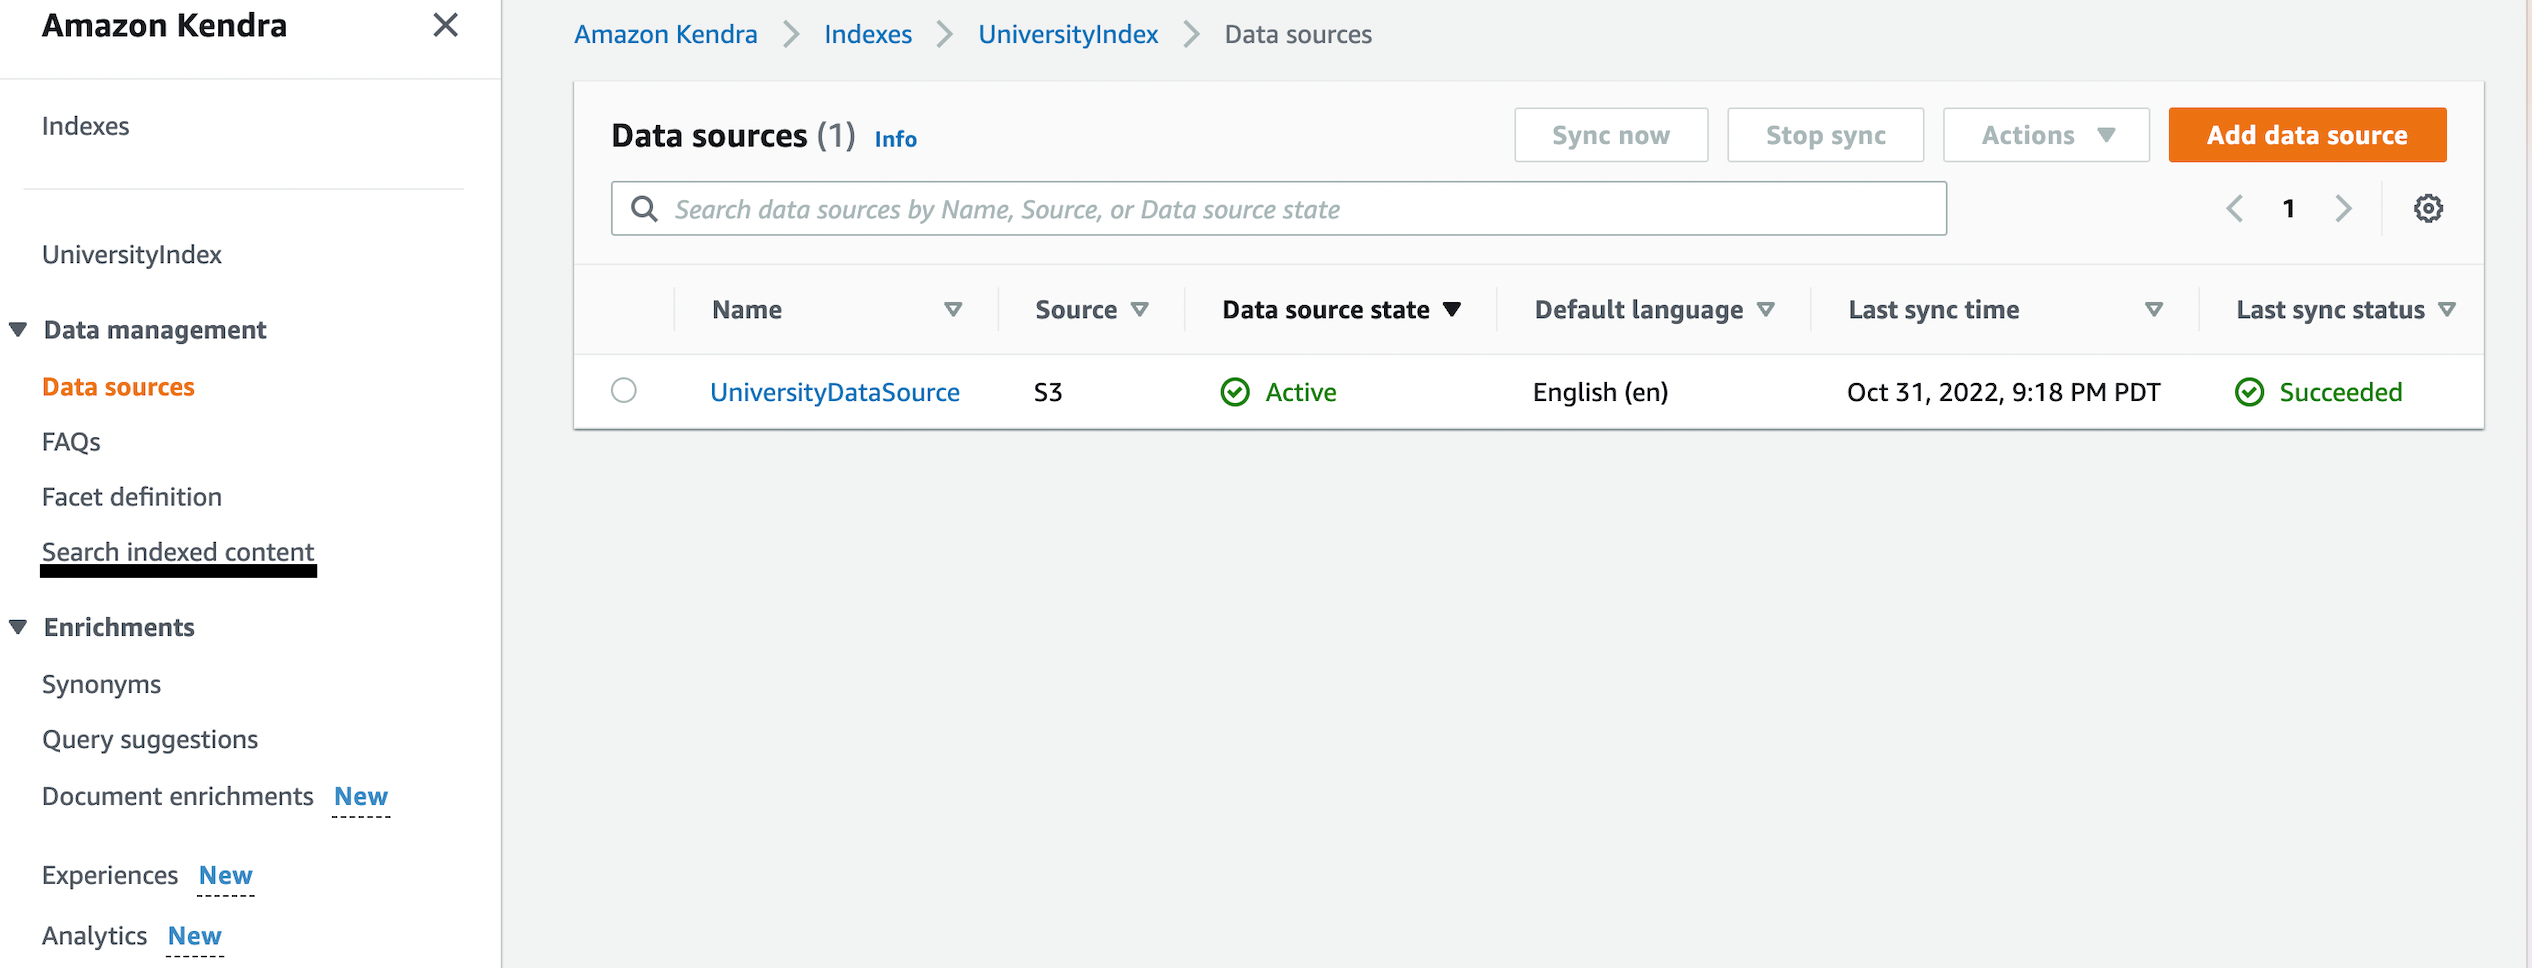

<b> 8.1 Try this query: How can I get aid for law school? </b>

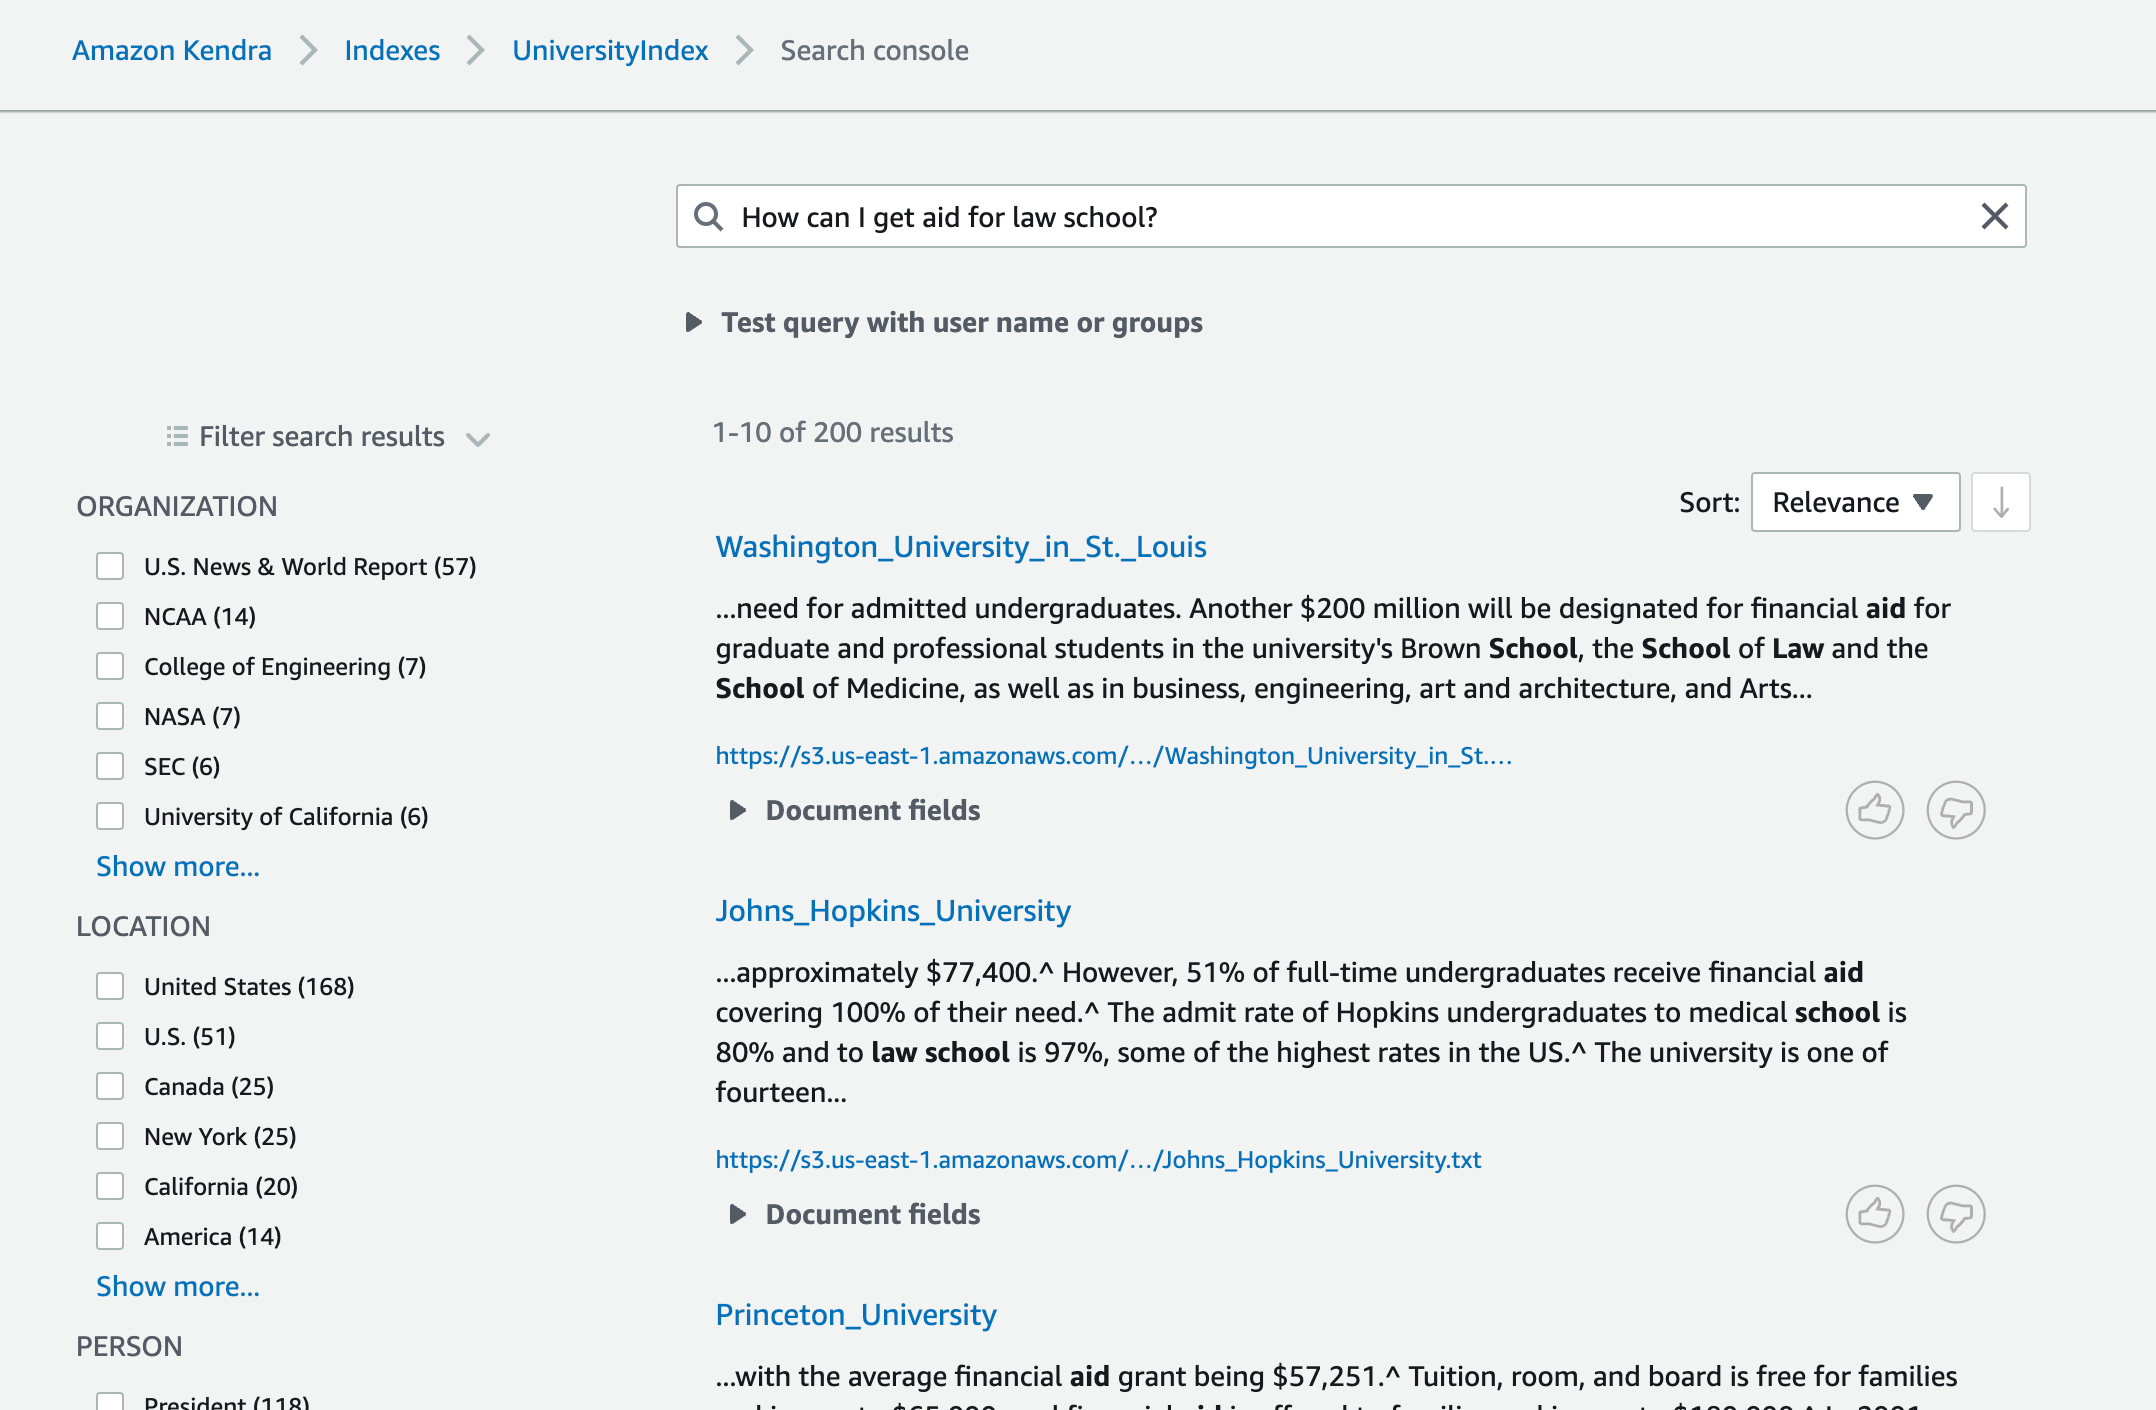

<b>The results show an answer from the Washington University in St. Louis Wikipedia page, followed others.
Choose “Filter search results” on the left. Now you will see all the Entity types and values extracted using Comprehend, and for each entity value you see the number of matching documents.</b><br />

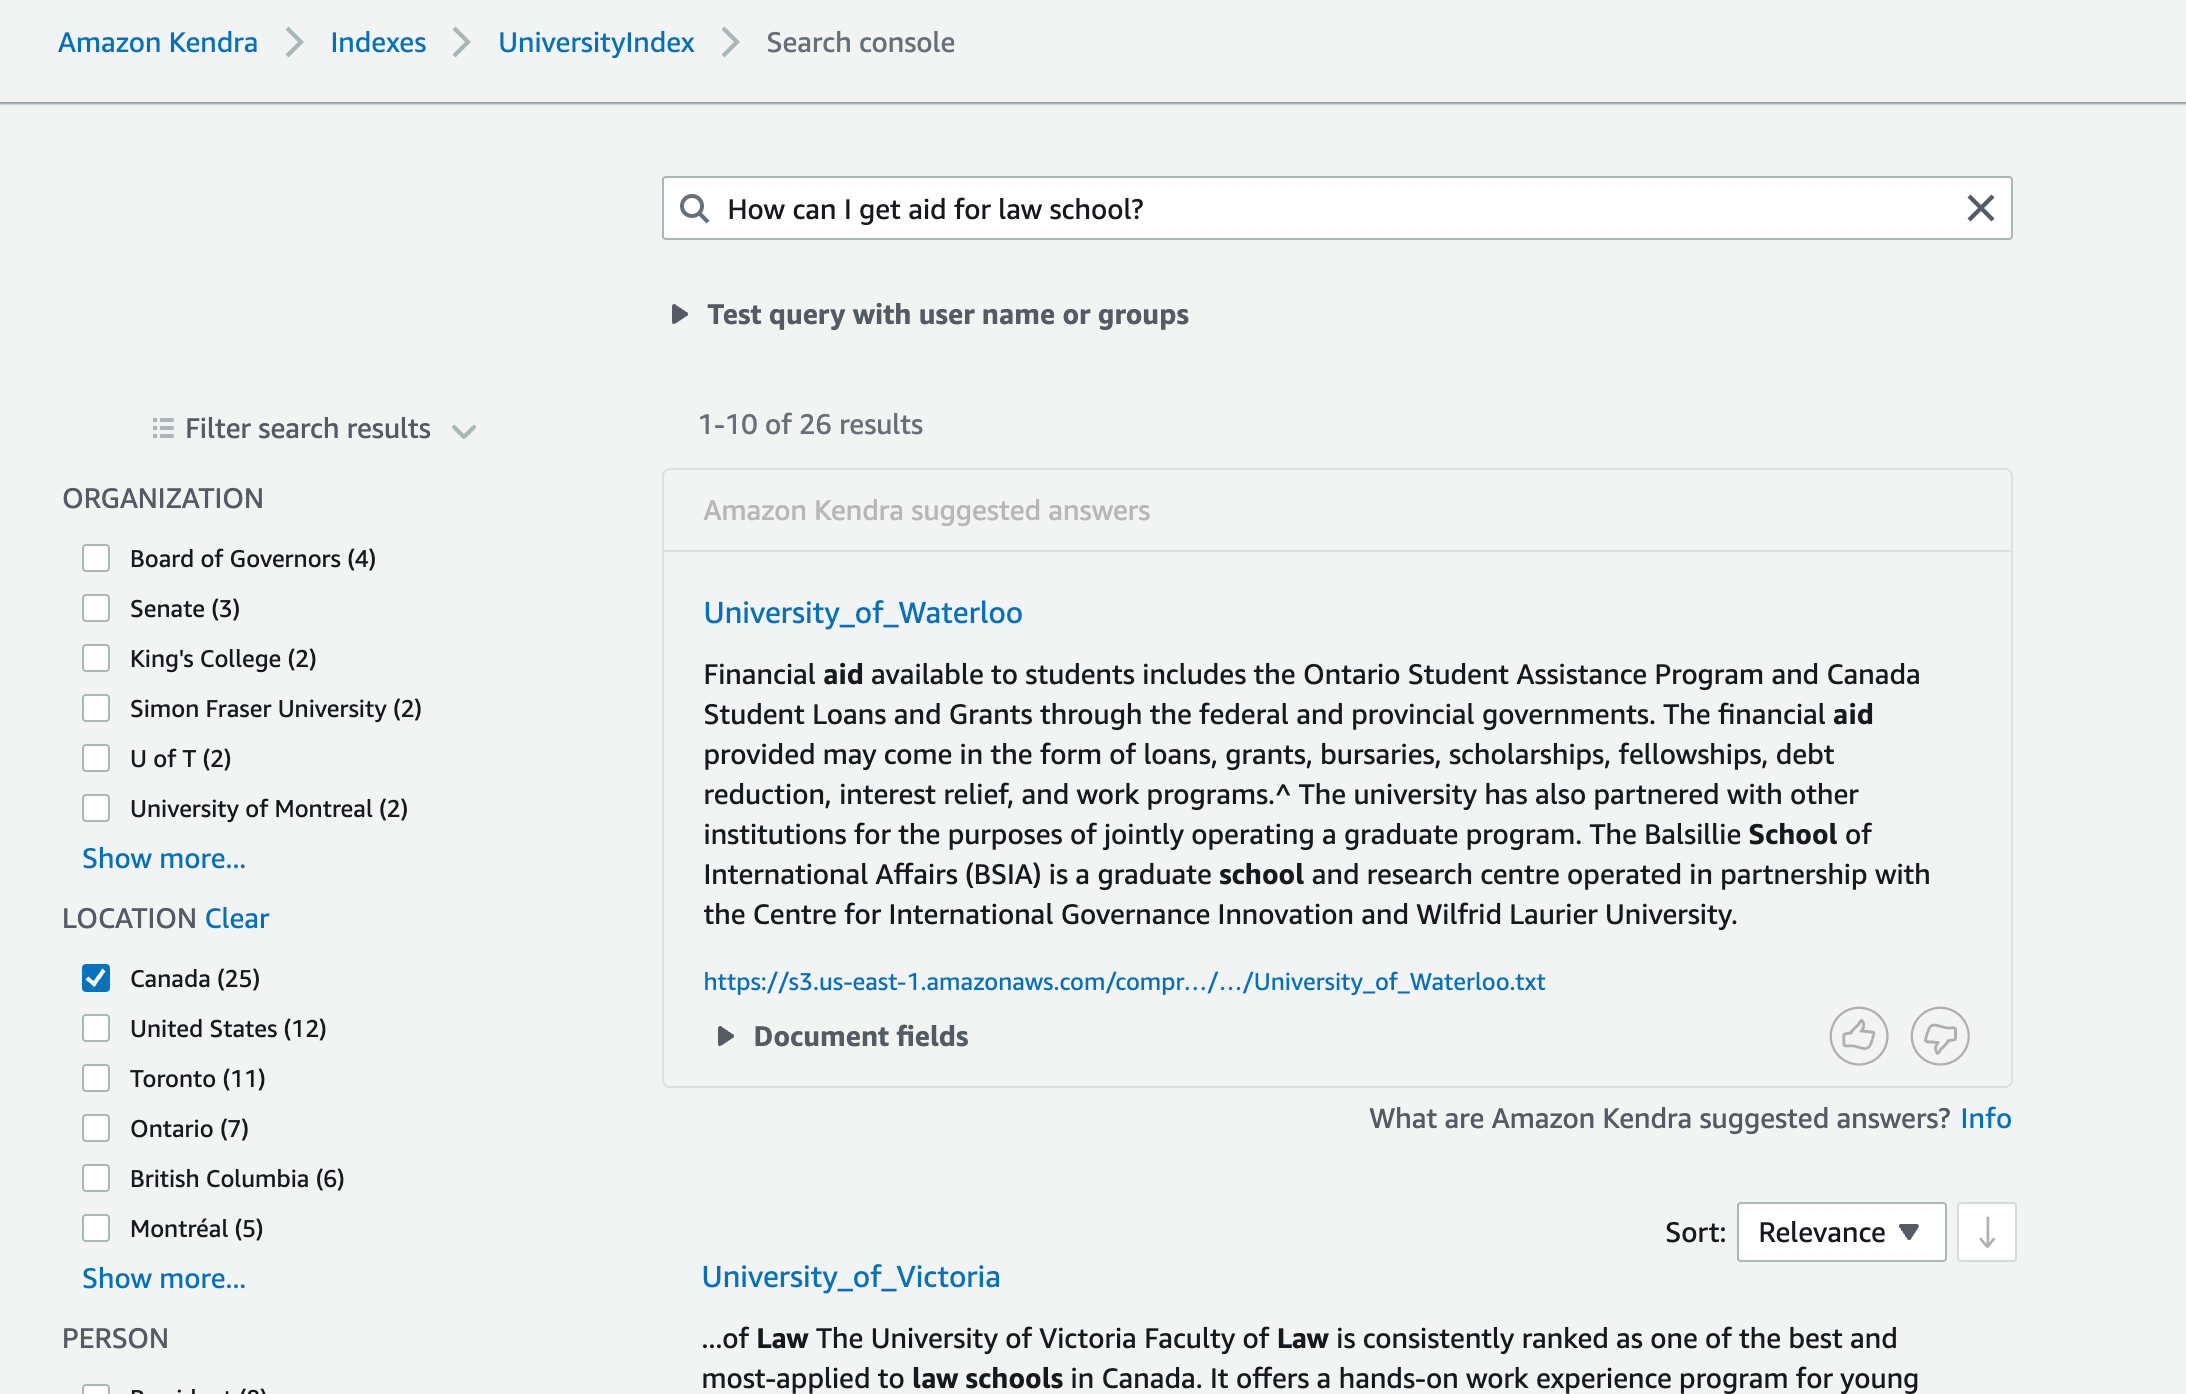

Under LOCATION choose “Canada”, and then you will get an answer from University of Waterloo.
Note: your results may vary slightly from the results shown in the screenshot.

Try searching with your own queries, and observe how the entities identified by Comprehend allow you quickly to:

* see how your search results are distributed across the categories
* narrow your search by filtering on any of the entity values.



# 9. Clean up

Delete the Cloudformation stack. Remove the Kendra index and data source to avoid ongoing costs associated with the index. See Kendra pricing. (https://aws.amazon.com/kendra/pricing/)

In [ ]:
# delete cfn stack
cloudformation.delete_stack(
    StackName='ComprehendLab8',
    RoleARN=sagemaker_role
)

In [ ]:
# delete Kendra data source
kendra.delete_data_source(
    Id=data_source_response["Id"],
    IndexId=index_id
)

In [ ]:
# delete Kendra index
kendra.delete_index(
    Id=index_id
)

In [ ]:
# delete policies and roles

# KendraDSRole and policy
iam.detach_role_policy(
    PolicyArn=f"arn:aws:iam::{account_id}:policy/KendraLab8DSPolicy",
    RoleName=kendra_data_source_role
)
iam.delete_policy(
    PolicyArn=f"arn:aws:iam::{account_id}:policy/KendraLab8DSPolicy"
)
iam.delete_role(
    RoleName=kendra_data_source_role
)


#KendraIndexRole and policy
iam.detach_role_policy(
    PolicyArn=f"arn:aws:iam::{account_id}:policy/KendraLab8IndexPolicy",
    RoleName=kendra_index_role
)
iam.delete_policy(
    PolicyArn=f"arn:aws:iam::{account_id}:policy/KendraLab8IndexPolicy"
)
iam.delete_role(
    RoleName=kendra_index_role
)


#Kendra Lambda role and policy
iam.detach_role_policy(
    PolicyArn=f"arn:aws:iam::{account_id}:policy/KendraLab8LambdaPolicy",
    RoleName=kendra_lambda_role
)
iam.delete_policy(
    PolicyArn=f"arn:aws:iam::{account_id}:policy/KendraLab8LambdaPolicy"
)
iam.delete_role(
    RoleName=kendra_lambda_role
)

In [ ]:
# Delete the S3 bucket
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)
bucket.objects.all().delete()

# <b>Conclusion</b>
<br />
In this lab you learned how to use Amazon Kendra CDE and Amazon Comprehend to tag content (University Wikipedia pages) with detected entity types and values that characterize the content. You saw how to use the content tags to create valuable metadata you added to your search index to make it possible to facet and filter your search results.
That's it. Congratulations on completing the lab!
